## Step 1: SOILSCAPE data

### This notebook performs the following:
- Reads existing list of SOILSCAPE sites and start/end datetimes
- Identifies NISAR track/frames that cover each site
- Pulls some other information about landcover, etc., from NISAR metadata files
- Initializes directory structure and json files containing above info

### Notes
- Sites that are within the overlap for two frames within a single NISAR track are currently associated with both frames (redundant)
- Each soilscape site contains profiles of observations at a range of depths, at between 1 and 6 locations.  We search the track/frame info for only the mean of these locations, since the sites are all within a few meters of it. It is possible that the cluster of sites could cross between track/frame boundaries.
- output file has columns:
    - dirName: Name of directory for each unique EASEGrid cell (includes SOILSCAPE siteName)
    - siteId: ID for each SOILSCAPE site (may contain >1 node and be covered by more than one EASEGrid cell)
    - siteName: Long name for each SOILSCAPE site
    - lat: Latitude in degrees of average of SOILSCAPE sites within EASEGrid cell
    - lon: Longitude in degrees of average of SOILSCAPE sties within EASEGrid cell
    - EASEGridRowIndex
    - EASEGridColIndex
    - lulc: Land use class from NISAR metadata
    - demstd: Std. dev. of topography from NISAR metadata
    - crop: for agricultural land use types, crop from NISAR metadata
    - nodes: SOILSCAPE nodes within each EASEGrid cell (between 1-6)
    - numnodes: Number of SOILSCAPE nodes located within each single EASEGrid cell
    - tracks: NISAR tracks covering centroid lat/lon of SOILSCAPE sites within EASEGrid cell
    - frames: NISAR frames covering centroid lat/lon of SOILSCAPE sites within EASEGrid cell 
    - tfNames: string containing combo of tracks and frames
    - framecount: number of NISAR track/frames covering centroid lat/lon of SOILSCAPE sites within EASEGrid cell

### Cite data as:
- A. Melebari et al., "CYGNSS SoilSCAPE Sites: Sensor Calibration and Data Analysis," IGARSS 2023 - 2023 IEEE International Geoscience and Remote Sensing Symposium, Pasadena, CA, USA, 2023, pp. 4628-4630, doi: 10.1109/IGARSS52108.2023.10282411.
- Use the digital object identifier provided in the id attribute when citing this data. See https://podaac.jpl.nasa.gov/CitingPODAAC ; 
- 10.5067/CSCAP-L1V10

### SOILSCAPE contacts:
- Amer Melebari, Ruzbeh Akbar, Erik Hodges, Darren McKague, Christopher S. Ruf, Agnelo Silva, Mahta Moghaddam
- amelebar@usc.edu, rakbar@mit.edu, ehodges@usc.edu, dmckague@umich.edu, cruf@umich.edu, agnelors@gmail.com , mahta@usc.edu

### More info at:
-  https://soilscape.usc.edu/sites-and-data/

### Necessary files
- soilscape_site_nodeLocations.csv - generated by hand using info from the main SOILSCAPE site (name,node#,lon,lat)

### Notes
- csv link of form https://soilscape.usc.edu/?csv_download_moisture=1&csv_download_moisture_site_id=25&valid_only=1&start_date=2022-05-04&end_date=2022-05-20
- fails above some unknown threshold, a month of data seems fine.

In [ ]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt

from utilsCalVal import EASEconvert
import setParams as p


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
soilscapePath       = p.soilscapePath
soilscapeNode       = p.soilscapeNode
trackFrameDb        = p.trackFrameDb 
anciStatic          = p.anciStatic

#output file: easegrid cells and info
soilscapeSitesPath = p.soilscapeSitesPath


In [3]:
#check files and make initial directory
Path(soilscapePath).mkdir(parents=True, exist_ok=True) #make soilscape directory if does not already exist
if not(os.path.isfile(soilscapeNode)):
    print('Error: need metadata file '+soilscapeNode+' with siteName,	siteIDNode,	longitude,	latitude')
if not(os.path.isfile(trackFrameDb)):
    print('Error - must download Track Frame database in order to match sites with NISAR frames, was at (restricted) https://drive.google.com/file/d/1_KbpgUGiYriUO18Rq7zKrTuXGAQl-Ksw/view?usp=sharing')
if not(os.path.isfile(anciStatic)):
    print('Error - need ancillary data file to assess land cover, etc.')  

## Read SOILSCAPE node info

In [4]:
sitesDF      = pd.read_csv(soilscapeNode,index_col=None)
nsites       = len(sitesDF)

siteName     = sitesDF['siteName']
siteIDNode   = sitesDF['siteIDNode']
siteLon      = sitesDF['longitude']
siteLat      = sitesDF['latitude']

siteID       = [str(x)[0:2] for x in siteIDNode] #overall site id, used in api call


## convert to EASEGRID


In [5]:

nsites     = len(sitesDF)
ezrowcol   = np.zeros((nsites,2),dtype=int)
sitesDF['ezdir']='null'
for i in range(nsites):
    lon              = sitesDF['longitude'][i]
    lat              = sitesDF['latitude'][i]
    ezc,ezr          = EASEconvert(lon,lat,1)
    ezrowcol[i,0]    = np.ceil(ezr-0.5)
    ezrowcol[i,1]    = np.ceil(ezc-0.5)  
    sitesDF.loc[i,'ezdir'] = 'r'+str(ezrowcol[i,0])+'c'+str(ezrowcol[i,1])+'_'+str(siteName[i])
      
sitesDF['ezr']       = ezrowcol[:,0]
sitesDF['ezc']       = ezrowcol[:,1]

#unique row/cols, plus indices from each station to unique row/col, and count of stations within each unique row/col
uniqueEZ,EZindices,EZcount = np.unique(ezrowcol,axis=0,return_inverse=True, return_counts=True)
nez = np.shape(uniqueEZ)[0]


/Users/rlohman/miniconda3/envs/SMCalVal/lib/python3.12/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
#read track/frame database
tfdb      = gpd.read_file(trackFrameDb,layer='tfdb')

In [7]:
#Open landcover, crop data (200mEASEGRID) and some dem info (1kmEASEGRID)
f         = h5py.File(anciStatic,'r')
d         = f['/landCover200m']
dc        = f['/cropmap200m']
ddem      = f['/dem1km'] #std deviation of heights within 1km cell, in meters
del f

In [ ]:
#saving most of the values we eventually put in a list of dictionaries as individual lists, for ease in plotting below.
sites=[]

for i in range(nez):
#for i in range(1):
        ezr     = uniqueEZ[i,0]
        ezc     = uniqueEZ[i,1]

        ezid    = np.nonzero(EZindices==i)[0]
        dirName = sitesDF['ezdir'][ezid[0]]

        nodes = []
        for j in range(len(ezid)):
                nodes.append(siteIDNode[ezid[j]])

        # Make a directory for each site 
        Path(soilscapePath+dirName).mkdir(parents=True, exist_ok=True)

        #Here, not worrying about cases where different sites in a cluster are in different NISAR frames
        lon = np.mean(siteLon[ezid]) 
        lat = np.mean(siteLat[ezid])


        #search track frame database
        tfdb0     = tfdb.iloc[tfdb.sindex.query(shapely.Point(lon,lat), predicate="intersects")]
        tracks    = tfdb0['track'].values.tolist()
        frames    = tfdb0['frame'].values.tolist()
        tfNames   = []
        for j in range(len(frames)):
                tfName='T'+str(tracks[j])+'F'+str(frames[j])
                tfNames.append(tfName)
                
        lulc      = int(d[ezr,ezc])
        crop      = int(dc[ezr,ezc])
        demstd       = float(ddem[np.floor(ezr/5).astype('int'),np.floor(ezc/5).astype('int')])

        #for now only save crop info if cropland
        if lulc!=4:
                crop=255

        tmpdct={'dirName':dirName,
                'siteID':siteID[ezid[0]],
                'siteName':siteName[ezid[0]],
                'lat':lat,
                'lon':lon,
                'EASEGridRowIndex':ezr,
                'EASEGridColIndex':ezc,
                'lulc':lulc,
                'demstd':demstd,
                'crop':crop,
                'nodes':nodes,
                'numnodes':len(ezid),
                'tracks':tracks,
                'frames':frames,
                'tfNames':tfNames,
                'framecount':len(frames)}
        sites.append(tmpdct)  

In [ ]:
###output CSV
newDF=pd.DataFrame(sites)
newDF.to_csv(soilscapeSitesPath,index=False)

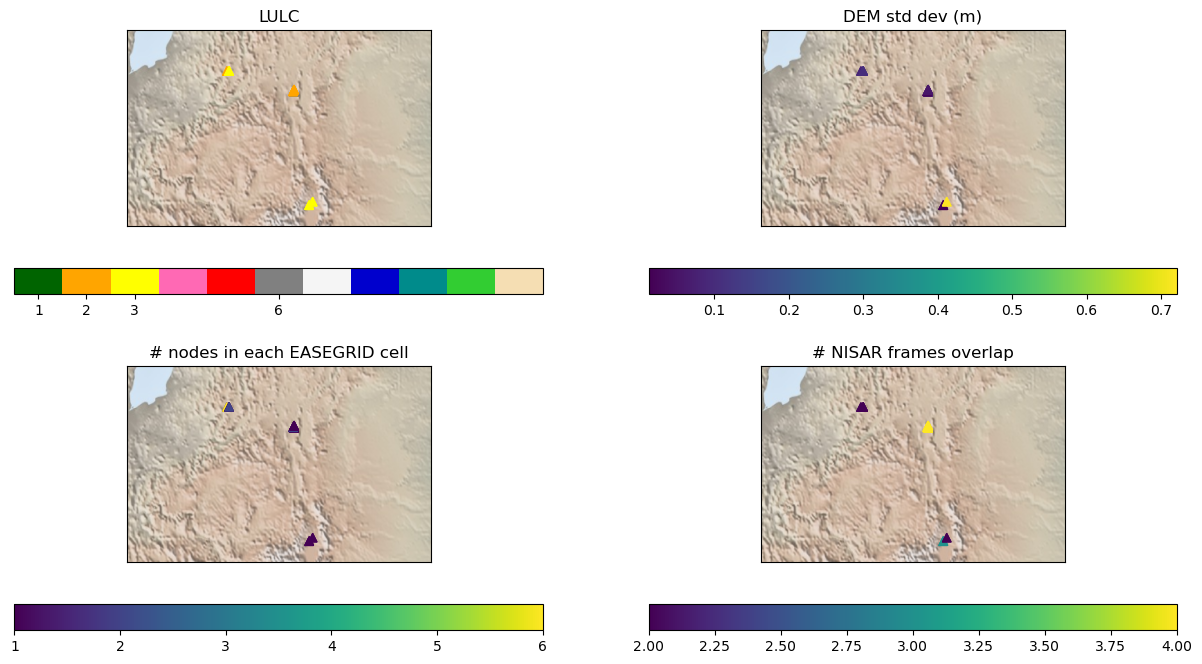

In [16]:
lon        = newDF['lon']
lat        = newDF['lat']
lulc       = newDF['lulc']
demstd     = newDF['demstd']
nnodes     = newDF['numnodes']
framecount = newDF['framecount']

fig,axes = plt.subplots(2,2,figsize=(15,8))
#lulc
m = Basemap(projection='merc',llcrnrlat=38,urcrnrlat=30,llcrnrlon=-115,urcrnrlon=-100,lat_ts=30,resolution=None,ax=axes[0,0])
m.shadedrelief()
cmap=matplotlib.colors.ListedColormap(('darkgreen','orange','yellow','hotpink','red','gray','whitesmoke','mediumblue','darkcyan','limegreen','wheat'))
c=m.scatter(lon,lat,c=lulc,marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True)
axes[0,0].set_title('LULC')
plt.colorbar(c,ax=axes[0,0],ticks=np.unique(lulc),orientation='horizontal')

#dem std. deviation within 1km grid cell
m = Basemap(projection='merc',llcrnrlat=38,urcrnrlat=30,llcrnrlon=-115,urcrnrlon=-100,lat_ts=30,resolution=None,ax=axes[0,1])
m.shadedrelief()
c=m.scatter(lon,lat,c=demstd,marker='^',latlon=True)
axes[0,1].set_title('DEM std dev (m)')
plt.colorbar(c,ax=axes[0,1],orientation='horizontal')

##nodes in each grid cell
m = Basemap(projection='merc',llcrnrlat=38,urcrnrlat=30,llcrnrlon=-115,urcrnrlon=-100,lat_ts=30,resolution=None,ax=axes[1,0])
m.shadedrelief()
c=m.scatter(lon,lat,c=nnodes,marker='^',latlon=True)
axes[1,0].set_title('# nodes in each EASEGRID cell')
plt.colorbar(c,ax=axes[1,0],orientation='horizontal')

#number of frames covering each site
m = Basemap(projection='merc',llcrnrlat=38,urcrnrlat=30,llcrnrlon=-115,urcrnrlon=-100,lat_ts=30,resolution=None,ax=axes[1,1])
m.shadedrelief()
c=m.scatter(lon,lat,c=framecount,marker='^',latlon=True)
axes[1,1].set_title('# NISAR frames overlap')
plt.colorbar(c,ax=axes[1,1],orientation='horizontal')

plt.show()


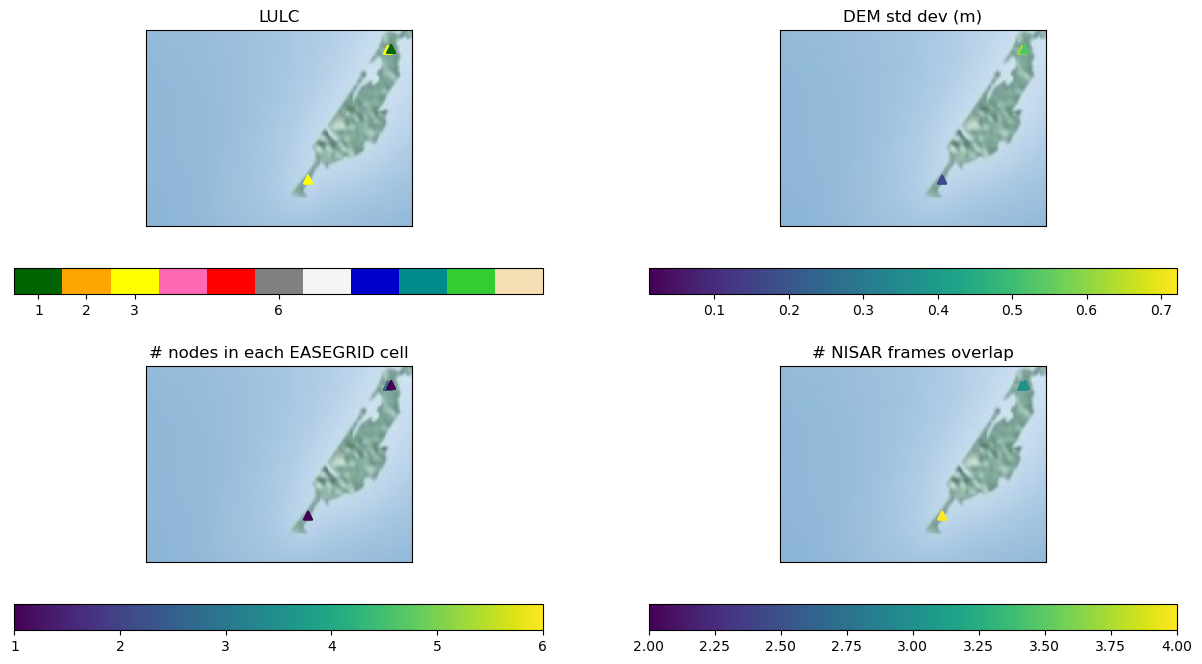

In [18]:
lon        = newDF['lon']
lat        = newDF['lat']
lulc       = newDF['lulc']
demstd     = newDF['demstd']
nnodes     = newDF['numnodes']
framecount = newDF['framecount']

fig,axes = plt.subplots(2,2,figsize=(15,8))
#lulc
m = Basemap(projection='merc',llcrnrlat=-34,urcrnrlat=-37,llcrnrlon=170,urcrnrlon=175,lat_ts=30,resolution=None,ax=axes[0,0])
m.shadedrelief()
cmap=matplotlib.colors.ListedColormap(('darkgreen','orange','yellow','hotpink','red','gray','whitesmoke','mediumblue','darkcyan','limegreen','wheat'))
c=m.scatter(lon,lat,c=lulc,marker='^',vmin=0.5,vmax=11.5,cmap=cmap,latlon=True)
axes[0,0].set_title('LULC')
plt.colorbar(c,ax=axes[0,0],ticks=np.unique(lulc),orientation='horizontal')

#dem std. deviation within 1km grid cell
m = Basemap(projection='merc',llcrnrlat=-34,urcrnrlat=-37,llcrnrlon=170,urcrnrlon=175,lat_ts=30,resolution=None,ax=axes[0,1])
m.shadedrelief()
c=m.scatter(lon,lat,c=demstd,marker='^',latlon=True)
axes[0,1].set_title('DEM std dev (m)')
plt.colorbar(c,ax=axes[0,1],orientation='horizontal')

##nodes in each grid cell
m = Basemap(projection='merc',llcrnrlat=-34,urcrnrlat=-37,llcrnrlon=170,urcrnrlon=175,lat_ts=30,resolution=None,ax=axes[1,0])
m.shadedrelief()
c=m.scatter(lon,lat,c=nnodes,marker='^',latlon=True)
axes[1,0].set_title('# nodes in each EASEGRID cell')
plt.colorbar(c,ax=axes[1,0],orientation='horizontal')

#number of frames covering each site
m = Basemap(projection='merc',llcrnrlat=-34,urcrnrlat=-37,llcrnrlon=170,urcrnrlon=175,lat_ts=30,resolution=None,ax=axes[1,1])
m.shadedrelief()
c=m.scatter(lon,lat,c=framecount,marker='^',latlon=True)
axes[1,1].set_title('# NISAR frames overlap')
plt.colorbar(c,ax=axes[1,1],orientation='horizontal')

plt.show()
